# <font color='#069af3'> Curve fitting - London rain</font>

## Introduction:

In this project, we aim to:

1. Retrieve weather data for London from 1980 to 2024 
2. Save the data in a dataframe format
3. Calculate how many days it rained each year 
4. Plot the rain days for each year
5. Apply a simple statistical analysis on the data
6. Data Interpolation
7. Curve fitting

### <font color='#069af3'> Database</font>:

We have chosen the Open Meteo API, which is a publicly available database, since it is user-friendly and has a fast response. In addition, it comes with comprehensive documentation and examples on how to convert the retrieved data into ``pandas`` 
dataframes.
<br>
The only problem we encountered was the number of allowed calls, which was very limited, as it will be further discussed in the second notebook.


_**Source: https://open-meteo.com/**_

## <font color='#069af3'>STEP 0</font>: Importing useful libraries

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

# API-specific library
import openmeteo_requests

# For calling the API
import requests_cache
from retry_requests import retry

# For curve fitting
from scipy.optimize import curve_fit

# For data interpolation
from scipy.signal import savgol_filter

## <font color='#069af3'>Step 1</font>: Retrieve data 

### 1a: Setup the Open-Meteo API client with cache and retry on error

We want to prepare to call the API of historical data, while creating a cache in order to save time, in case we will need to call the API again. Also, we allow for 5 retries in case the call returns an error.

In [2]:
# Create cache
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)

# Allow for 5 retries
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)

# Create client instance
openmeteo = openmeteo_requests.Client(session = retry_session)

### 1b: Define parameters

Now, we will specify exactly which data to retrieve from the database. According to the documentation, the input parameters need to be:
* The Latitude and Longitude of the desired location
* The start and end date of the historic data 
* The time zone of the specified location
<br>
<br>
Here, we will request weather data for London, which is within the "Europe/London" time zone, starting from the 8th of July 1980 up to the 28th of July 2024.

In [3]:
# Specify parameters
lat_Ldn = 51.5085 # latitude 
long_Ldn = -0.1257 # longitude 
str_date = "1980-07-08"
end_date = "2024-07-28"
time = "Europe/London" # timezone

In order for the database to recognise the input parameters, we will incorporate them into a dictionary.
<br>
We also have to specify the resolution of the data and which weather variables we will need. Here, we are asking for the **minimum temperature** (in °C) and the **amount of rain** (in mm) of the **daily** weather.


In [4]:
# Dictionary containing parameters and type of requested data
params = {
	"latitude": lat_Ldn,
	"longitude": long_Ldn,
	"start_date": str_date,
	"end_date": end_date,
	"daily": ["temperature_2m_min", "rain_sum"], # minimum T; daily rain
	"timezone": time
}

### 1c: Call API
Now, we can finally call the API, given the corresponding link. 
<br>
We will save its first response, which corresponds to the first (and only) location, London.

In [5]:
# Historical data API link
url = "https://archive-api.open-meteo.com/v1/archive"

# Get response from API with the given parameters
responses = openmeteo.weather_api(url, params=params)

# Process first location (1st response)
response = responses[0]

## <font color='#069af3'>Step 2</font>: Convert requested data into a dataframe

Now, we can retrieve the weather data from the response. We will first isolate each of the variables of interest and save them into a dictionary.
<br>
These variables are the ...
* Date
* Minimum temperature
* Daily rain
<br>
<br>
Finally, we will build a pandas dataframe from this dictionary. 
For this, we will save the values of each column (or key) of the dictionary into a dataframe column. At the same time, we will name each of the dataframe columns accordingly.

In [6]:
# Retrieve the daily data from the response 
daily = response.Daily()

# Isolate the minimum daily temperature (array)
daily_temperature_2m = daily.Variables(0).ValuesAsNumpy() 

# Isolate the daily rain (array)
daily_rain = daily.Variables(1).ValuesAsNumpy() 


# Put together the data (date; min T; rain) into a dictionary 
daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}


# Build a pandas dataframe 

# Generate the "temperature_MIN" column from the the values of the "daily_temperature_2m" dictionary key
daily_data["temperature_MIN"] = daily_temperature_2m 

# Generate the "rain" column from the values of the "daily_rain" dictionary key
daily_data["rain"] = daily_rain # rain

# Put together the dataframe
daily_dataframe = pd.DataFrame(data = daily_data)

# Print the dataframe 
print(daily_dataframe)

                           date  temperature_MIN       rain
0     1980-07-07 23:00:00+00:00          11.1000  14.700001
1     1980-07-08 23:00:00+00:00          11.2000   5.700000
2     1980-07-09 23:00:00+00:00           9.6000   0.000000
3     1980-07-10 23:00:00+00:00          11.7000   0.600000
4     1980-07-11 23:00:00+00:00           9.8000   0.900000
...                         ...              ...        ...
16087 2024-07-23 23:00:00+00:00          13.9065   0.500000
16088 2024-07-24 23:00:00+00:00          15.8065   2.300000
16089 2024-07-25 23:00:00+00:00          13.0065   0.000000
16090 2024-07-26 23:00:00+00:00          12.6565   0.000000
16091 2024-07-27 23:00:00+00:00          11.4065   0.000000

[16092 rows x 3 columns]


## <font color='#069af3'>Step 3</font>: Calculate how many days it rained each year 

Now that we have all of the weather data we need gathered in a handy dataframe format, we seek to calculate _how many days per year_ it rained in London from 1980 to 2024. According to the definition, we would say that a day is "rainy" if the precipitation exceeds 1mm.

### 3a: Split the dataframe: one df for each year

We thought it would be easier to calculate the rainy days in a year, if the data for this year were gathered in one, separate dataframe.
<br>
<br>
First, we needed to identify the year corresponding to each data point. 
The "date" column of the dataframe was in the form year-month-day 23:00:00+00:00, e.g. 1980-07-07 23:00:00+00:00. From the date, we isolated the year, using the ``pd.to_datetime`` pandas function, which converts a dataframe value into a datetime object. We saved the year into a new column of the dataframe, with the same name. 
<br>
_**Source**: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html_
<br>
<br>
As a second step, we removed the time part (23:00:00+00:00) from the "date" values. This step was optional, and it only served in having a better-looking dataframe.
<br>
<br>
Finally, we found the unique values of the "years" column and generated a separate dataframe for each unique value. This resulted in a list of dataframes, one for each year.
<br>
<br>
_**Note**: We did not divide the rainy days by 365, because of the leap years._

In [7]:
# Step 1: Isolate year, using the pd.to_datetime function
daily_dataframe['year'] = pd.to_datetime(daily_dataframe['date']).dt.year

# Print 1st date
print("Date before editing:" + "    " + str(daily_dataframe['date'].iloc[0]) + "\n")

# Print 1st year
print("Year:" + "    " + str(daily_dataframe['year'].iloc[0]) + "\n")

# Step 2: Replace date/time time stamp w/ only date
daily_dataframe['date'] = pd.to_datetime(daily_dataframe['date']).dt.date

# Print 1st date
print("Date after editing:" + "    " + str(daily_dataframe['date'].iloc[0]) + "\n")

# Step 3: Split df according to year (using list comprehension)
yearly_df = [daily_dataframe[daily_dataframe['year'] == k] for k in np.unique(daily_dataframe['year'])]

# Print df for 1980
print("Dataframe for 1980:" + "\n" + str(yearly_df[0]))

Date before editing:    1980-07-07 23:00:00+00:00

Year:    1980

Date after editing:    1980-07-07

Dataframe for 1980:
           date  temperature_MIN       rain  year
0    1980-07-07            11.10  14.700001  1980
1    1980-07-08            11.20   5.700000  1980
2    1980-07-09             9.60   0.000000  1980
3    1980-07-10            11.70   0.600000  1980
4    1980-07-11             9.80   0.900000  1980
..          ...              ...        ...   ...
173  1980-12-27            -1.05   0.000000  1980
174  1980-12-28             6.20   0.000000  1980
175  1980-12-29             7.55   0.000000  1980
176  1980-12-30             7.30   0.000000  1980
177  1980-12-31             3.85   0.000000  1980

[178 rows x 4 columns]


### 3b: Count the rainy days per year

Now, we can calculate the rainy days in one year, using the ``np.where`` function.
<br>
<br>
The ``np.where`` function finds the elements of the array, which fulfill a certain condition, and returns their indices. Here, our condition was that the value of the "rain" column should be greater than 1. This simply means that the precipitation should be greater than 1mm for that day. Instead of returning the indices of the elements fulfilling the rain condition, we calculated their length, since the purpose was just to count them.
<br>
_**Source**: https://numpy.org/doc/stable/reference/generated/numpy.where.html_
<br>
<br>
We first counted the rainy days in 1980 and then applied the same logic for the whole dataset, using a list comprehension.
<br>
<br>
Finally, we generated a new dataframe, containing only the year and the number of rainy days.
<br>
<br>
_**Note**: We used ``np.where`` instead of a for loop in order to save on computational time. The same is true for the list comprehension in the place of a loop._

In [8]:
# Count rainy days for 1980
count_1980 = len(np.where( (yearly_df[0]["rain"] > 1) )[0])

# Repeat for all years (list comprehension)
tot_rain_year = [len(np.where( (yearly_df[k]["rain"] > 1) )[0]) for k in range(0, len(yearly_df))]

# Generate new df: year; rainy days 
rain_year_df = pd.DataFrame()
rain_year_df["year"] = np.unique(daily_dataframe['year'])  # add year
rain_year_df["rain_count"] = tot_rain_year  # add rain count

# Print new dataframe
print("New dataframe:" + "\n" + str(rain_year_df))

New dataframe:
    year  rain_count
0   1980          54
1   1981         121
2   1982         130
3   1983         118
4   1984         110
5   1985         122
6   1986         133
7   1987         122
8   1988         125
9   1989         101
10  1990         107
11  1991         105
12  1992         125
13  1993         119
14  1994         120
15  1995         100
16  1996          95
17  1997         112
18  1998         134
19  1999         126
20  2000         146
21  2001         139
22  2002         130
23  2003          91
24  2004         130
25  2005         105
26  2006         124
27  2007         111
28  2008         121
29  2009         109
30  2010         105
31  2011          90
32  2012         136
33  2013         122
34  2014         141
35  2015         130
36  2016         111
37  2017         130
38  2018         119
39  2019         142
40  2020         135
41  2021         130
42  2022         119
43  2023         135
44  2024          88


## <font color='#069af3'>Step 4</font>:  Plot rainy days for each year 

### 4a: Plot data
Now, we will plot the data of our last dataframe, rain count vs year, to visualise them.

Text(0.5, 1.0, 'Rainy Days per Year in London 1980-2024')

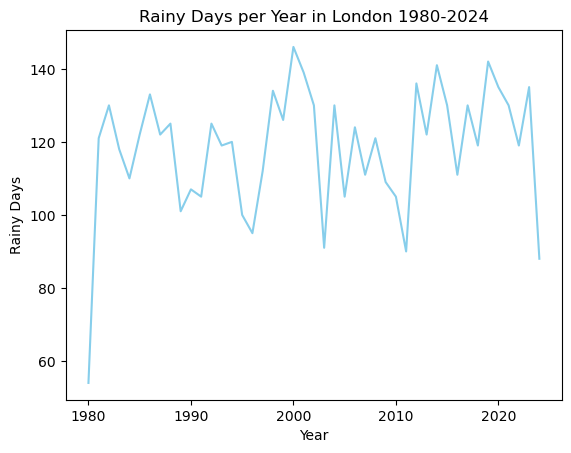

In [22]:
plt.figure()
plt.plot(rain_year_df["year"], rain_year_df["rain_count"], color = "skyblue")
plt.xlabel("Year")
plt.ylabel("Rainy Days")
plt.title("Rainy Days per Year in London 1980-2024")

### 4b: Crop data and replot

We can see that the rainy days for 1980 (first value) and for 2024 (last value) are significantly less, compared to the other years. This is because we started collecting data on the July of 1980, not the 1st of January of 1980. Thus, we have significantly less days for 1980 compared to the other years in our dataset. Hence, it makes sense that the rain count is also smaller. The same is true for 2024, where we stopped collecting data in the July of that year.
<br>
<br>
Because of these two extreme values, the overall "shape" of the plot is altered, obscuring the main trends. Also, we will apply some simple statistics in _Step 5_, which will be more accurate if the extremities are ignored.

Text(0.5, 1.0, 'Rainy Days per Year in London 1981-2023')

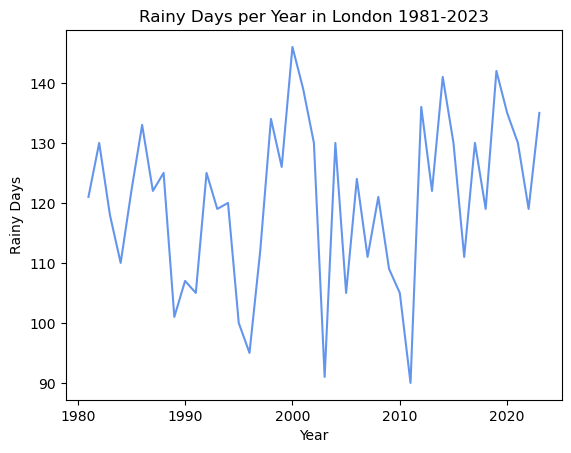

In [26]:
# Exclude 1980 (1st element) and 2024 (last element)
df_cropped = rain_year_df[1:-1] 
    
# Plot cropped data 
plt.figure()
plt.plot(df_cropped["year"], df_cropped["rain_count"], color = "cornflowerblue")
plt.xlabel("Year")
plt.ylabel("Rainy Days")
plt.title("Rainy Days per Year in London 1981-2023")

## <font color='#069af3'>Step 5</font>: Simple Statistical Analysis

We will now calculate the average rainy days per year in London and the standard error, using the build-in ``np.average`` and ``np.std`` Python functions and print the results.

In [12]:
# Average rain per year
AVG_rain_days = int(np.average(df_cropped["rain_count"]))

# Standard error
std_err_rain = int(np.std(df_cropped["rain_count"]))

# Print AVG +/- std error; % error
print(f"In average in London it rains {AVG_rain_days} \u00B1 {std_err_rain} days a year")

In average in London it rains 120 ± 13 days a year


## <font color='#069af3'>Step 6</font>: Data Interpolation

From the plot of the rainy days per year (step 4b), we can see that there is a hint of periodicity in the data. 
<br>
Before proceding to curve fitting, we wanted to understand whether there is indeed an underlying pattern or the trends we see are caused by noise. For this, we first wanted to to get rid of the noise, by "smoothing" the data. 

To interpolate the data, we used the Savitzky-Golay filter (``savgol_filter``). 
This filter fits a low-order polynomial function on a small window of the data at a time. Both the order of the polynomial and the window length are specified by the user.
Here, we picked a 3rd order polynomial and a sliding window of 8 datapoints after experimenting with different values.
<br>
We picked the SavGol function for the interpolation as it is better in preserving the shape of the data when removing the high frequency noise, compared to other filters.
<br>
<br>
_**Source**: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html_
<br>
_**Source**: https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter_
<br>
_**Source**: https://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html_

Text(0.5, 1.0, 'Rainy Days per Year in London 1981-2023')

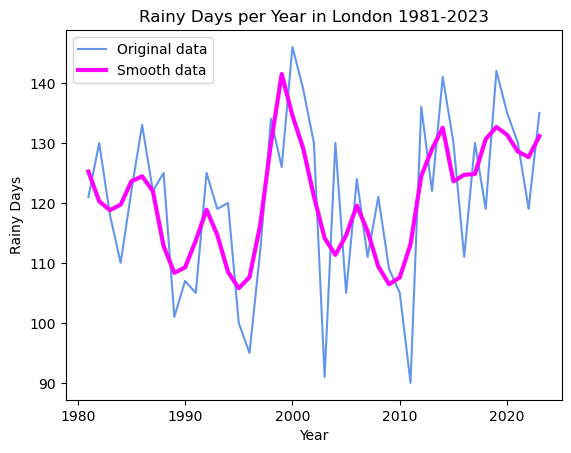

In [31]:
# Sliding window size (in nbr of datapoints)
window_len = 8 

# Polynomial order
pol_order = 3 

# Apply SavGol filter
rain_smooth_crp = savgol_filter(df_cropped["rain_count"], window_len, pol_order) 

# Plot
plt.figure()

# Original data
plt.plot(df_cropped["year"], df_cropped["rain_count"], color = "cornflowerblue")  

# Smooth data
plt.plot(df_cropped["year"], rain_smooth_crp, color = "fuchsia", linewidth = 3)

# Add legend for each plot
plt.legend(["Original data", "Smooth data"])

# Labels/ Title
plt.xlabel("Year")
plt.ylabel("Rainy Days")
plt.title("Rainy Days per Year in London 1981-2023")

Upon interpolation (magenta line), it is clear the data follows a periodic-looking pattern.

## <font color='#069af3'>Step 7</font>: Curve Fitting

### 7a: Which function?

Now, we seek a function to fit on the smoothed data. 
Even though we observe a periodic pattern, we exclude the simple trigonometric functions (eg sine, cosine).
This is because the peaks have different heights between them, indicating the presence of multiple amplitudes.
<br>
<br>
Therefore, we would need a generic periodic function, which results from the sum of sines and cosines, each having a different amplitude. This leads us to the Fourier series, a suitable representation for such complex periodic behavior.
<br>
<br>
After some experimentation, we concluded that a third order Fourier series fits our dataset the best. This takes the form:

$f(x) = A_{0} + A_{1} \cos(\omega x) + B_{1} \sin(\omega x) + A_{2} \cos(2 \omega x) + B_{2} \sin(2 \omega x) + A_{3} \cos(3 \omega x) + B_{3} \sin(3 \omega x)$,

with $\omega = \frac{2 \pi}{T}$
<br>
<br>
_**Source**: https://en.wikipedia.org/wiki/Fourier_series_

### 7b: Parametrisation

Now that we have the form of the function in hand, we need to fit the parameters. First, we can estimate some of them from the interpolated plot.
<br>
<br>
We can see that we have one pattern repetition within the time studied, which is about 40 years (1981 to 2023). Also, the pattern is mirrored after roughly 20 years (2000 to 2010). From these two observations, we can tell that the period ($T$) of the periodic function is about 20 years. From the period, we can also calculate $\omega$.
<br>
<br>
Finally, $A_{0}$ is simply the average value of the dependent variable, i.e. the rainy days.

In [35]:
# Estimated Parameters 

# Period (in years)
T = 20 

# ω
omega = 2 * np.pi / T  

# A0
avg_val = np.average(df_cropped["rain_count"])  
A0 = avg_val 

However, we cannot estimate the different amplitudes (A1, B1, A2, B2, A3, B3) as easily.
<br>
We can estimate the amplitudes, using the Python ``curve_fit`` function, which fits the desired parameters to the given function, when they are passed as inputs.

Text(0.5, 1.0, 'Fourier fitted function')

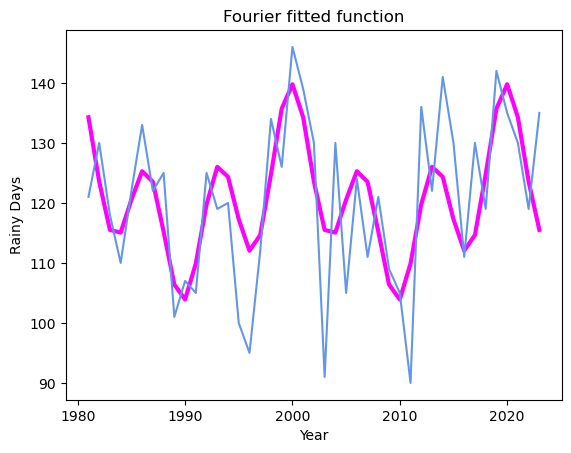

In [40]:
# Define Fourier series 
def Fourier_fun(x, A1, B1, A2, B2, A3, B3):
    
    # INPUTS: x = years, A1...B3 = all params to fit;
    
    y = A0 + A1 * np.cos(omega * x) + B1 * np.sin(omega * x) \
    + A2 * np.cos(2 * omega * x) + B2 * np.sin(2 * omega * x) \
    + A3 * np.cos(3 * omega * x) + B3 * np.sin(3 * omega * x) 
    
    return y

# Find A1, B1, A2, B2, A3, B3  by fitting function
popt, pcov = curve_fit(Fourier_fun, df_cropped["year"], df_cropped["rain_count"])

# Fitted function
y_fit = Fourier_fun(df_cropped["year"], *popt)

# Plot fitted function
plt.plot(df_cropped["year"], y_fit, color = "fuchsia", linewidth = 3) 

# Plot original data
plt.plot(df_cropped["year"], df_cropped["rain_count"], color = "cornflowerblue")  

# Labels; Title
plt.xlabel("Year")
plt.ylabel("Rainy Days")
plt.title("Fourier fitted function")

### <font color='#069af3'>Conclusion?</font>

The rainy days per year in London from 1981 to 2023 can be expressed as a third order Fourier series.